# 3.4: 量子线路模块化编程

In [1]:
# |default_exp tensor_gates.modules
# |export
import torch
from torch import nn
from tensor_network.tensor_gates import functional
from typing import List, Literal
from tensor_network.utils.checking import check_quantum_gate
from tensor_network.utils.mapping import view_gate_tensor_as_matrix, view_gate_matrix_as_tensor

In [2]:
# |export


class QuantumGate(nn.Module):
    """
    Base class for quantum gates.
    """

    def __init__(
        self,
        *,
        batched_input: bool,
        gate_name: str | None = None,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ):
        """
        Args:
            batched_input: Whether the input is batched.
            gate_name: Name of the gate.
            target_qubit: The qubit(s) to which the gate is applied. If None, this should be set in the forward method.
            control_qubit: The control qubit(s) for controlled gates.
        """
        super().__init__()
        if target_qubit is not None:
            assert isinstance(target_qubit, (int, list)), "target_qubit must be int or list of int"
        if control_qubit is not None:
            assert isinstance(control_qubit, (int, list)), (
                "control_qubit must be int or list of int"
            )
        self.gate_name = gate_name
        self.target_qubit = target_qubit
        self.control_qubit = control_qubit
        self.batched_input = batched_input

    def apply_gate(
        self,
        *,
        tensor: torch.Tensor,
        gate: torch.Tensor,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ) -> torch.Tensor:
        target_qubit = self.target_qubit if target_qubit is None else target_qubit
        control_qubit = self.control_qubit if control_qubit is None else control_qubit
        assert target_qubit is not None, "target_qubit must be specified or set in the gate"
        if self.batched_input:
            return functional.apply_gate_batched(
                quantum_states=tensor,
                gate=gate,
                target_qubit=target_qubit,
                control_qubit=control_qubit,
            )
        else:
            return functional.apply_gate(
                quantum_state=tensor,
                gate=gate,
                target_qubit=target_qubit,
                control_qubit=control_qubit,
            )

    def forward(self, *args, **kwargs) -> torch.Tensor:
        raise NotImplementedError(
            "QuantumGate is an abstract class and should not be used directly.\nYou should implement your own gate class by inheriting from QuantumGate and make use of the apply_gate method."
        )


class ParameterizedGate(QuantumGate):
    """
    A parameterized quantum gate is a gate that has latent parameters for gate tensor.
    """

    def __init__(
        self,
        *,
        batched_input: bool,
        gate_params: nn.ParameterDict | torch.Tensor,
        requires_grad: bool | None = None,
        gate_name: str | None = None,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ):
        """
        Args:
            batched_input: Whether the input is batched.
            gate_params: The parameters of the gate.
            requires_grad: If True, the gate tensor will be a trainable parameter.
            gate_name: Name of the gate.
            target_qubit: The qubit(s) to which the gate is applied.
            control_qubit: The control qubit(s) for controlled gates.
        """
        super().__init__(
            batched_input=batched_input,
            gate_name=gate_name,
            target_qubit=target_qubit,
            control_qubit=control_qubit,
        )
        assert isinstance(gate_params, (nn.ParameterDict, torch.Tensor)), (
            "gate_params must be a nn.ParameterDict or torch.Tensor"
        )
        if isinstance(gate_params, torch.Tensor):
            self.gate_params = nn.Parameter(
                gate_params,
                requires_grad=gate_params.requires_grad if requires_grad is None else requires_grad,
            )
        else:
            self.gate_params = gate_params

    def forward(self, *args, **kwargs) -> torch.Tensor:
        raise NotImplementedError(
            "ParameterizedGate is an abstract class and should not be used directly.\nYou should implement your own gate class by inheriting from ParameterizedGate and make use of the apply_gate method."
        )


class SimpleGate(QuantumGate):
    """
    A simple quantum gate is a gate that has a gate tensor.
    """

    def __init__(
        self,
        *,
        batched_input: bool,
        gate: torch.Tensor,
        requires_grad: bool | None = None,
        gate_name: str | None = None,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ):
        """
        Args:
            batched_input: Whether the input is batched.
            gate: The tensor representation of the quantum gate.
            requires_grad: If True, the gate tensor will be a trainable parameter.
            gate_name: Name of the gate.
            target_qubit: The qubit(s) to which the gate is applied.
            control_qubit: The control qubit(s) for controlled gates.

        """
        super().__init__(
            batched_input=batched_input,
            gate_name=gate_name,
            target_qubit=target_qubit,
            control_qubit=control_qubit,
        )
        assert isinstance(gate, torch.Tensor), "gate must be a torch.Tensor"
        check_quantum_gate(gate)
        self.gate = nn.Parameter(
            gate, requires_grad=gate.requires_grad if requires_grad is None else requires_grad
        )

    def forward(
        self,
        tensor: torch.Tensor,
        *,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ) -> torch.Tensor:
        return self.apply_gate(
            tensor=tensor,
            gate=self.gate,
            target_qubit=target_qubit,
            control_qubit=control_qubit,
        )


class PauliGate(SimpleGate):
    """
    Pauli gates (X, Y, Z, ID) are single-qubit gates that can be applied to a quantum state.
    """

    def __init__(
        self,
        *,
        gate_name: Literal["X", "Y", "Z", "ID"],
        batched_input: bool,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
        double_precision: bool = False,
        force_complex: bool = False,
    ):
        """
        Args:
            gate_name: Name of the Pauli gate. Must be one of "X", "Y", "Z", or "ID".
            batched_input: Whether the input is batched.
            target_qubit: The qubit(s) to which the gate is applied. If not specified, this should be set in the forward method.
            control_qubit: The control qubit(s) for controlled gates.
            double_precision: If True, use double precision for the gate tensor.
            force_complex: If True, force the gate tensor to be complex.
        """
        self.is_identity = gate_name == "ID"
        gate = functional.pauli_operator(
            pauli=gate_name, double_precision=double_precision, force_complex=force_complex
        )
        super().__init__(
            gate=gate,
            requires_grad=False,
            gate_name=gate_name,
            target_qubit=target_qubit,
            control_qubit=control_qubit,
            batched_input=batched_input,
        )

    def forward(
        self,
        tensor: torch.Tensor,
        *,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ) -> torch.Tensor:
        if self.is_identity:
            return tensor
        else:
            return super().forward(tensor, target_qubit=target_qubit, control_qubit=control_qubit)


class ADQCGate(ParameterizedGate):
    """
    Automatically differentiable quantum circuit gate (ADQC) is a trainable quantum gate.
    """

    def __init__(
        self,
        *,
        batched_input: bool,
        target_qubit_num: int | None = None,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
        gate_name: str | None = None,
        double_precision: bool = False,
        identity_init: bool = False,
    ):
        """
        Args:
            batched_input: Whether the input is batched.
            target_qubit_num: Number of target qubits.
            target_qubit: The qubit(s) to which the gate is applied.
            control_qubit: The control qubit(s) for controlled gates.
            gate_name: Name of the gate.
            double_precision: If True, use double precision for the gate tensor.
            identity_init: If True, initialize the gate tensor with identity matrix + a bit random noise.
        """

        if target_qubit_num is None:
            assert target_qubit is not None, (
                "target_qubit_num must be specified if target_qubit is None"
            )
            target_qubit_num = 1 if isinstance(target_qubit, int) else len(target_qubit)
        else:
            tq_num = 1 if isinstance(target_qubit, int) else len(target_qubit)
            assert tq_num == target_qubit_num, (
                "target_qubit_num must be equal to the length of target_qubit"
            )

        gate_shape = [2] * (2 * target_qubit_num)
        latent_gate_tensor = torch.randn(
            *gate_shape, dtype=torch.complex128 if double_precision else torch.complex64
        )

        if identity_init:
            P, S, Q = torch.linalg.svd(view_gate_tensor_as_matrix(latent_gate_tensor))
            S_new = torch.ones_like(S) + 0.001 * torch.randn_like(S)
            S_new = S_new.reshape(-1, 1)
            latent_gate_matrix = P @ (S_new * Q)
            latent_gate_tensor = view_gate_matrix_as_tensor(latent_gate_matrix)

        super().__init__(
            gate_params=latent_gate_tensor,
            requires_grad=True,
            gate_name=gate_name,
            target_qubit=target_qubit,
            control_qubit=control_qubit,
            batched_input=batched_input,
        )

    def forward(
        self,
        tensor: torch.Tensor,
        *,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ) -> torch.Tensor:
        P, _S, Q = torch.linalg.svd(view_gate_tensor_as_matrix(self.gate_params))
        gate_matrix = P @ Q
        gate = view_gate_matrix_as_tensor(gate_matrix)
        return self.apply_gate(
            tensor=tensor, gate=gate, target_qubit=target_qubit, control_qubit=control_qubit
        )


class RotateGate(ParameterizedGate):
    def __init__(
        self,
        *,
        batched_input: bool,
        gate_name: str | None = None,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
        double_precision: bool = False,
    ):
        """
        Args:
            batched_input: Whether the input is batched.
            gate_name: Name of the gate.
            target_qubit: The qubit(s) to which the gate is applied. If not specified, this should be set in the forward method.
            control_qubit: The control qubit(s) for controlled gates.
            double_precision: If True, use double precision for the gate tensor.
        """

        dtype = torch.float64 if double_precision else torch.float32

        params = nn.ParameterDict(
            {
                "ita": nn.Parameter(torch.randn((), dtype=dtype), requires_grad=True),
                "beta": nn.Parameter(torch.randn((), dtype=dtype), requires_grad=True),
                "delta": nn.Parameter(torch.randn((), dtype=dtype), requires_grad=True),
                "gamma": nn.Parameter(torch.randn((), dtype=dtype), requires_grad=True),
            }
        )

        super().__init__(
            gate_params=params,
            requires_grad=True,
            gate_name=gate_name,
            target_qubit=target_qubit,
            control_qubit=control_qubit,
            batched_input=batched_input,
        )

    def forward(
        self,
        tensor: torch.Tensor,
        *,
        target_qubit: int | List[int] | None = None,
        control_qubit: int | List[int] | None = None,
    ) -> torch.Tensor:
        rotate_gate = functional.rotate(
            ita=self.gate_params["ita"],
            beta=self.gate_params["beta"],
            delta=self.gate_params["delta"],
            gamma=self.gate_params["gamma"],
        )
        return self.apply_gate(
            tensor=tensor, gate=rotate_gate, target_qubit=target_qubit, control_qubit=control_qubit
        )

## Tests

In [3]:
state = torch.randn(2, 2, dtype=torch.complex64)

pauli_x = PauliGate(
    batched_input=False, gate_name="X", target_qubit=0, control_qubit=1, force_complex=True
)
s1 = pauli_x(state)

adqc_gate = ADQCGate(
    batched_input=False,
    target_qubit_num=1,
    target_qubit=0,
    control_qubit=1,
    gate_name="ADQC",
    identity_init=True,
)
s2 = adqc_gate(state)

rotate = RotateGate(batched_input=False, gate_name="Rotate", target_qubit=0, control_qubit=1)
s3 = rotate(state)

## Training

![aqdc-example](./images/adqc_code_example.png)

In [4]:
from torch.optim import Adam
import matplotlib.pyplot as plt
from tensor_network.utils.tensors import zeros_state
from tqdm.auto import tqdm

lr = 1e-3
iterations = 1500
num_qubits = 3

  0%|          | 0/1500 [00:00<?, ?it/s]

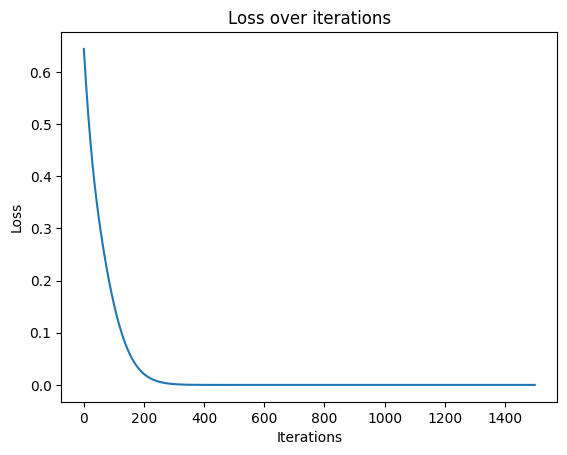

In [5]:
target_state = torch.randn(*([2] * num_qubits), dtype=torch.complex64)
target_state = target_state / target_state.norm()

model = nn.Sequential(
    ADQCGate(batched_input=False, target_qubit=[0, 1], gate_name="ADQC0"),
    ADQCGate(batched_input=False, target_qubit=[1, 2], gate_name="ADQC1"),
    ADQCGate(batched_input=False, target_qubit=[0, 1], gate_name="ADQC2"),
    ADQCGate(batched_input=False, target_qubit=[1, 2], gate_name="ADQC3"),
)

optimizer = Adam(model.parameters(), lr=lr)
losses = torch.empty(iterations, dtype=torch.float32)


for i in tqdm(range(iterations)):
    state = zeros_state(num_qubits=num_qubits, dtype=torch.complex64)
    state = model(state)
    loss = 1 - (state.conj() * target_state).sum().norm()
    losses[i] = loss.detach()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()